<a href="https://colab.research.google.com/github/matt-chv/mmWrt/blob/main/docs/FMCW-Radar%20201-CFAR_Pd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FMCW Radar 202 - CFAR Pd Pfa Pmiss

## Executive summary

CFAR (peak finding) in its different variants defines a threshold as a function of neighbouring cells adjacent values to minimise `false-alert` the correlate is tht the __false-negative rate will be a function of the noise__ (see below for details).

Design trade-off options:

1. Measure Noise (details TBD) and enter `safe state` when noise too high
2. proceed to M-out-of-N (aka `binary integration`) see below for details to decrease Pmiss when SNR too high and increase the FTTI accordingly




## LITTERATURE REVIEW

### COMPARISON OF CFARS
> [Performance Analysis of CFAR Detector Based on Censored Mean and Cell Average](https://iopscience.iop.org/article/10.1088/1742-6596/1237/2/022029/pdf)
> doi:10.1088/1742-6596/1237/2/022029

### Performance Analysis of the Censored Mean-Level Detector
> https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4104234
    
> Mean-level detectors are commonly used in radar to maintain a constant false-alarm rate (CFAR) when the background noise level is unknown [...] When the reference channel consists of independent and identically distributed (i.i.d.) noise samples from the same population as contained by the cell under test under the
null hypothesis, this detector is the uniformly most powerful (UMP) test whose false-alarm probability is invariant to the noise level [...]

<font style="color:red">
A number of authors [3, 8-11] have shown that the detection performance of the MLD can be severely degraded when the assumption of a locally homogeneous noise environment is violated.
<u>Interfering or outlying targets that fall within the surrounding range cells raise the threshold and reduce the detection probability; they can arise from either real object returns or pulsed noise jamming.</u>
</font>

## IWR6843 COR

* NF = 12 dB (as per datasheet)
* RCS = 0.17m2 (as per IEC 61496)
* max Tx power = 12 dBm = 16 mW (FCC value ?!?)

$$ P_{R} = \frac{P_T \cdot G^2 \cdot \lambda^2}{(4 \cdot \pi)^3 \cdot R^4} $$

Where:

* PR = received power
* PT = Transmitted power
* G = Antenna Gain
* sigma = RCS target
* R = distance to target

In [ ]:
# PR at Dmax = 5m
from numpy import pi, log10
R = 5
PT = 16e-3
f = 60e9
c = 3e8
G_dBi =  8 # dBi
G = 10**(G_dBi/10)
# print("G",G)
lambda0 = c/f
PR = PT * G**2 * lambda0*2/(4*pi)**3/R**4
print("PR (W)",PR)
PR_dB = 10 * log10(PR/1e-3)
print("PR dB", PR_dB)

PR (W) 5.1358268476838975e-09
PR dB -52.89389626754439


## THEORETICAL STUDY for Receiver Operating Characteristic (ROC)

> credit [roc in python](https://towardsdatascience.com/receiver-operating-characteristic-curves-demystified-in-python-bd531a4364d0)

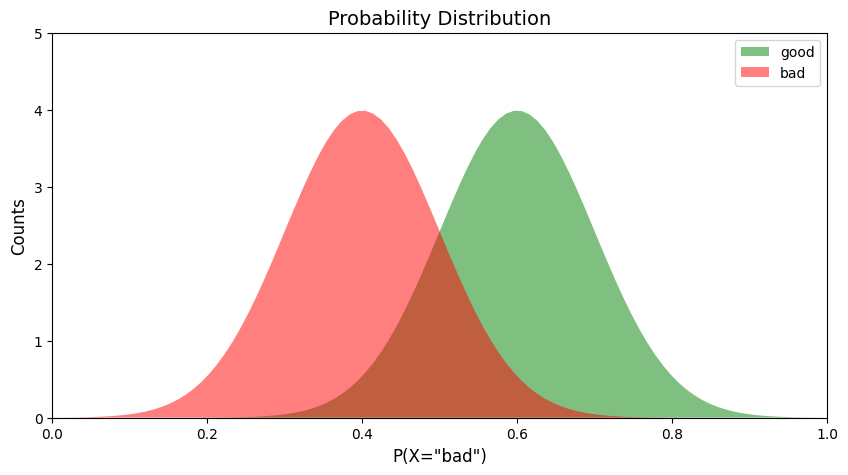

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def pdf(x, std, mean):
    const = 1.0 / np.sqrt(2*np.pi*(std**2))
    pdf_normal_dist = const*np.exp(-((x-mean)**2)/(2.0*(std**2)))
    return pdf_normal_dist
x = np.linspace(0, 1, num=100)
good_pdf = pdf(x,0.1,0.6)
bad_pdf = pdf(x,0.1,0.4)

def plot_pdf(good_pdf, bad_pdf, ax):
    ax.fill(x, good_pdf, "g", alpha=0.5)
    ax.fill(x, bad_pdf,"r", alpha=0.5)
    ax.set_xlim([0,1])
    ax.set_ylim([0,5])
    ax.set_title("Probability Distribution", fontsize=14)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlabel('P(X="bad")', fontsize=12)
    ax.legend(["good","bad"])

fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax)

low noise -> Pmiss ~0 (gaussian) xe miss 0.14500000000000002
44 3.345736870929259e-07
higher noise -> increased Pmiss xe miss 0.445
44 0.07615894663550861
high noise -> high Pmiss xe miss 0.545
44 0.6042812783574958


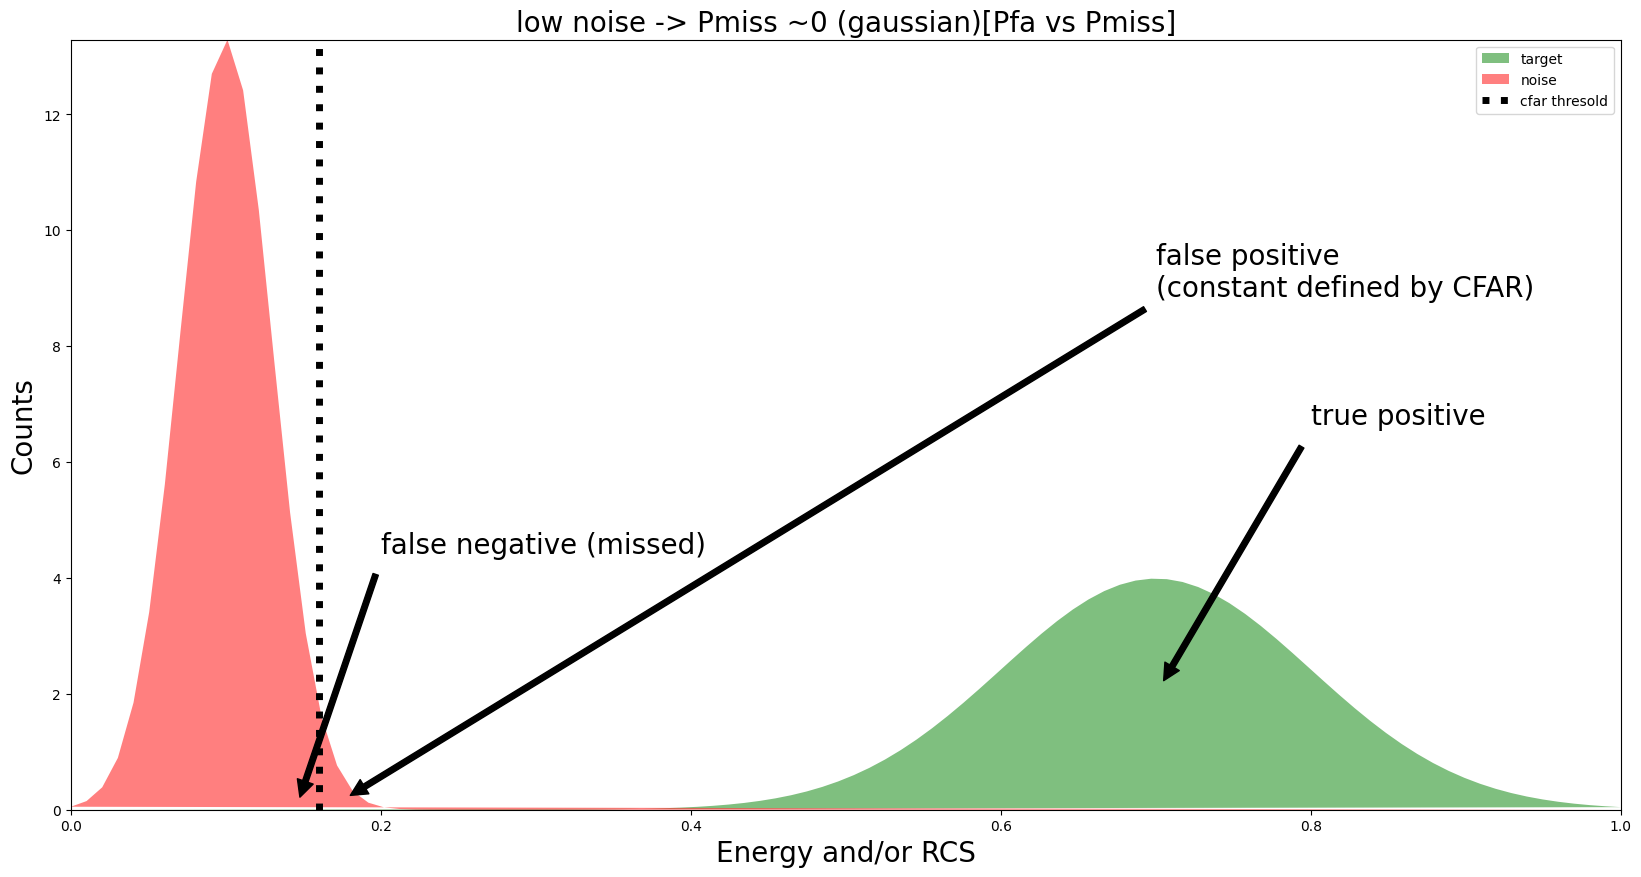

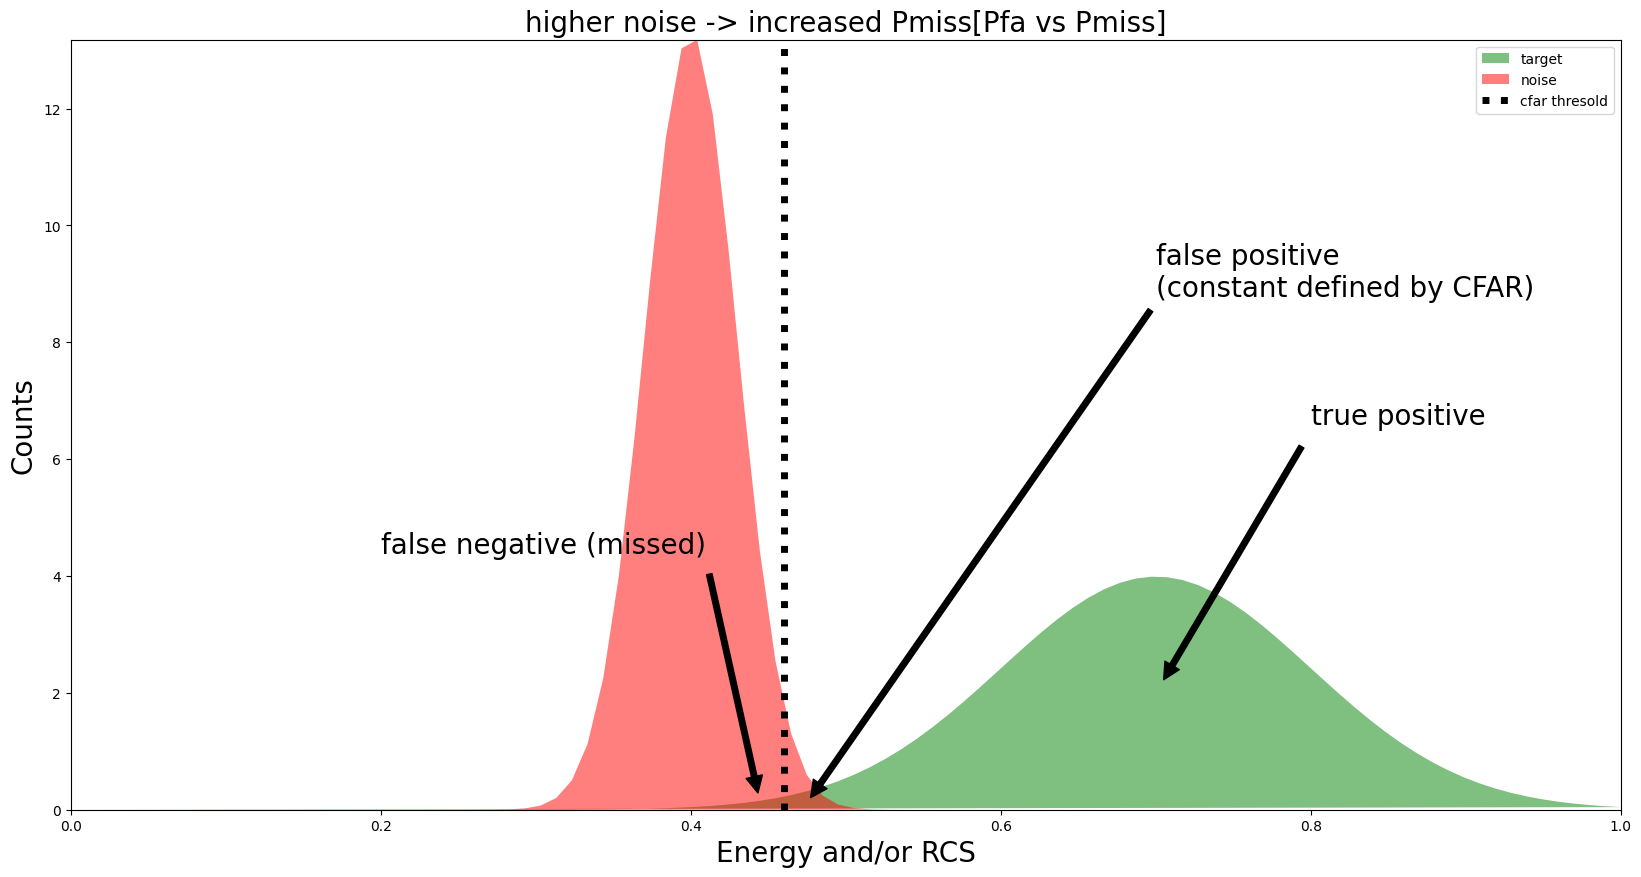

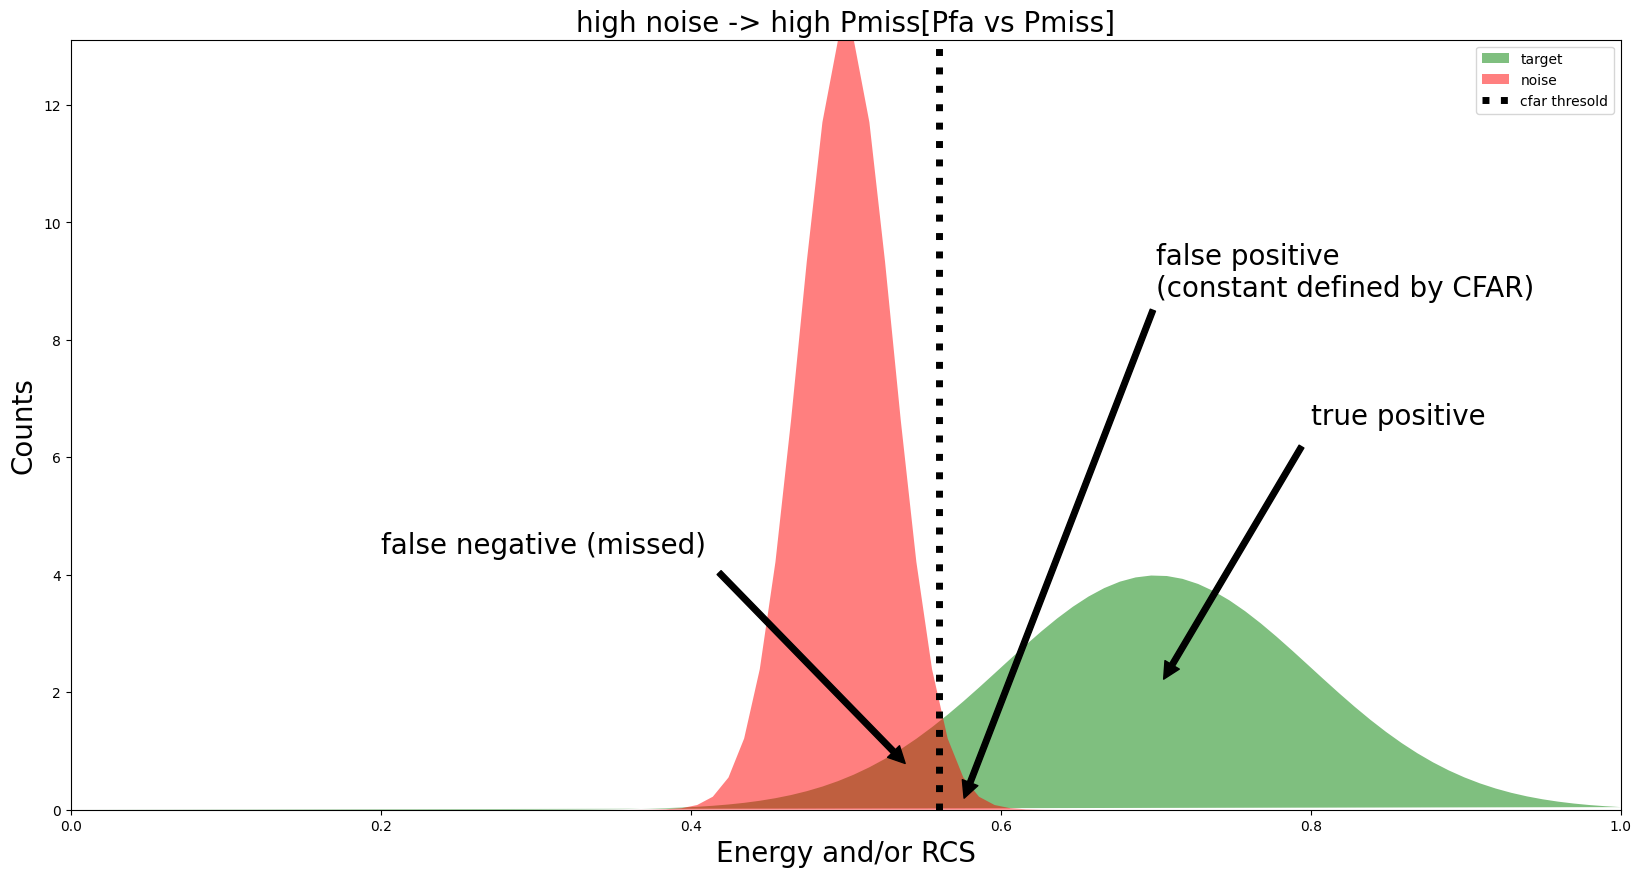

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def pdf(x, mu_std):
    mean, std,  = mu_std
    const = 1.0 / np.sqrt(2*np.pi*(std**2))
    pdf_normal_dist = const*np.exp(-((x-mean)**2)/(2.0*(std**2)))
    return pdf_normal_dist
x = np.linspace(0, 1, num=100)

def plot_cfar(good, bad, ax, cfar_ratio=2, title="CFAR and Pmiss"):
    good_pdf = pdf(x,good)
    bad_pdf = pdf(x,bad)
    yMg=max(good_pdf)
    yMb=max(bad_pdf)
    yM = max(yMg, yMb)

    mean, std,  = bad
    cfar_th = mean + cfar_ratio*std
    ax.fill(x, good_pdf, "g", alpha=0.5)
    ax.fill(x, bad_pdf,"r", alpha=0.5)
    ax.set_xlim([0,1])
    ax.set_ylim([0,yM])
    ax.set_title(title+"[Pfa vs Pmiss]", fontsize=20)
    ax.set_ylabel('Counts', fontsize=20)
    ax.set_xlabel('Energy and/or RCS', fontsize=20)
    ax.vlines(x=cfar_th,ymin=0,ymax=yM,colors='black', ls=':', lw=5,
              label='CFAR threshold')

    xe = cfar_th+std/2
    ye = bad_pdf[int(xe*100)+1] /2
    ax.annotate(f'false positive \n(constant defined by CFAR)', xy=(xe, ye), xytext=(0.7, yM*2/3),
            arrowprops=dict(facecolor='black', shrink=0.01), fontsize=20)

    ax.annotate(f'true positive', xy=(0.7, 2), xytext=(0.8, yM/2),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

    xe = cfar_th-std/2
    print(title,"xe miss",xe)
    ye = good_pdf[int(xe*100)]/2
    print(44,ye)
    ax.annotate(f'false negative (missed)', xy=(xe,ye), xytext=(0.2, yM*1/3),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

    ax.legend(["target","noise","cfar thresold"])

def plot_cfar_rayleigh_rician(good, bad, ax, cfar_ratio=2, title="CFAR and Pmiss"):
    pass

fig, ax = plt.subplots(1,1, figsize=(20,10))
plot_cfar((0.7,0.1), (0.1,0.03), ax, title="low noise -> Pmiss ~0 (gaussian)")
fig, ax = plt.subplots(1,1, figsize=(20,10))
plot_cfar((0.7,0.1), (0.4,0.03), ax, title="higher noise -> increased Pmiss")
fig, ax = plt.subplots(1,1, figsize=(20,10))
plot_cfar((0.7,0.1), (0.5,0.03), ax, title="high noise -> high Pmiss")

### Signal and Noise Modelling

* Noise in FFT is modelled by a Rayleigh distribution
* Signal is best modelled by a Rician distribution

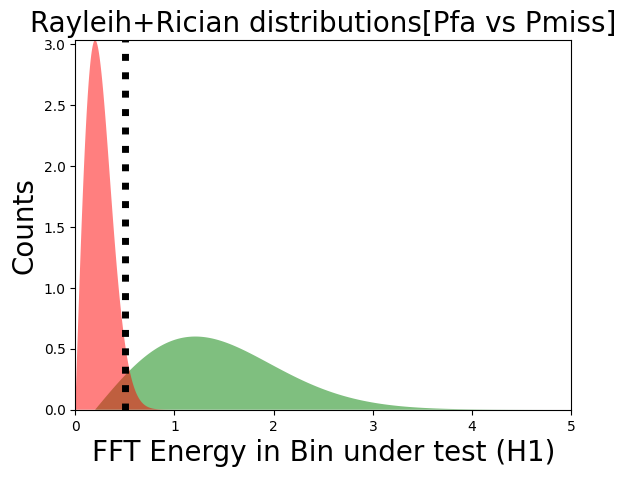

In [47]:
from scipy.stats import rayleigh, rice

def plot_rayleigh_rician(ax, good, bad, cfar_ratio=2, title="Rayleih+Rician distributions"):
    xm, xM = 0, 5
    x = np.linspace(xm, xM, num=1000)
    cfar_th = 0.5
    good_pdf = rice.pdf(x, b=0.2, loc=0.2)
    bad_pdf = rayleigh.pdf(x, 0, 0.2)
    yMg=max(good_pdf)
    yMb=max(bad_pdf)
    yM = max(yMg, yMb)

    ax.fill(x, good_pdf, "g", alpha=0.5)
    ax.fill(x, bad_pdf,"r", alpha=0.5)
    ax.set_xlim([xm,xM])
    ax.set_ylim([0,yM])
    ax.set_title(title+"[Pfa vs Pmiss]", fontsize=20)
    ax.set_ylabel('Counts', fontsize=20)
    ax.set_xlabel('FFT Energy in Bin under test (H1)', fontsize=20)
    ax.vlines(x=cfar_th,ymin=0,ymax=yM,colors='black', ls=':', lw=5,
              label='CFAR threshold')
fig, ax = plt.subplots(1,1) #, figsize=(20,10))
plot_rayleigh_rician(ax, (0.7,0.1), (0.7,0.1))

## ROC curve

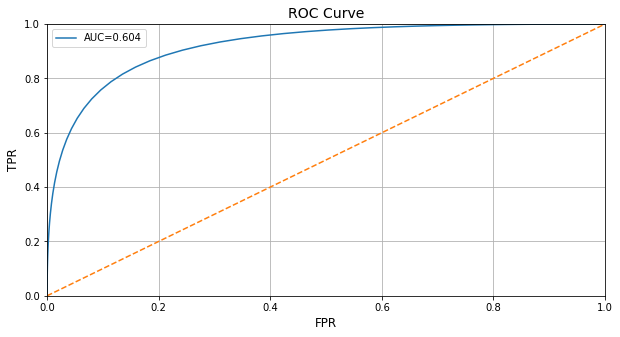

In [ ]:
def plot_roc(good_pdf, bad_pdf, ax):
    #Total
    total_bad = np.sum(bad_pdf)
    total_good = np.sum(good_pdf)
    #Cumulative sum
    cum_TP = 0
    cum_FP = 0
    #TPR and FPR list initialization
    TPR_list=[]
    FPR_list=[]
    #Iteratre through all values of x
    for i in range(len(x)):
        #We are only interested in non-zero values of bad
        if bad_pdf[i]>0:
            cum_TP+=bad_pdf[len(x)-1-i]
            cum_FP+=good_pdf[len(x)-1-i]
        FPR=cum_FP/total_good
        TPR=cum_TP/total_bad
        TPR_list.append(TPR)
        FPR_list.append(FPR)
    #Calculating AUC, taking the 100 timesteps into account
    auc=np.sum(TPR_list)/100
    #Plotting final ROC curve
    ax.plot(FPR_list, TPR_list)
    ax.plot(x,x, "--")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title("ROC Curve", fontsize=14)
    ax.set_ylabel('TPR', fontsize=12)
    ax.set_xlabel('FPR', fontsize=12)
    ax.grid()
    ax.legend(["AUC=%.3f"%auc])
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_roc(good_pdf, bad_pdf, ax)

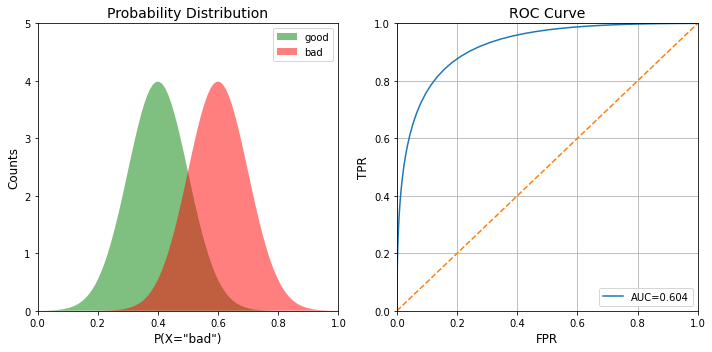

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax[0])
plot_roc(good_pdf, bad_pdf, ax[1])
plt.tight_layout()

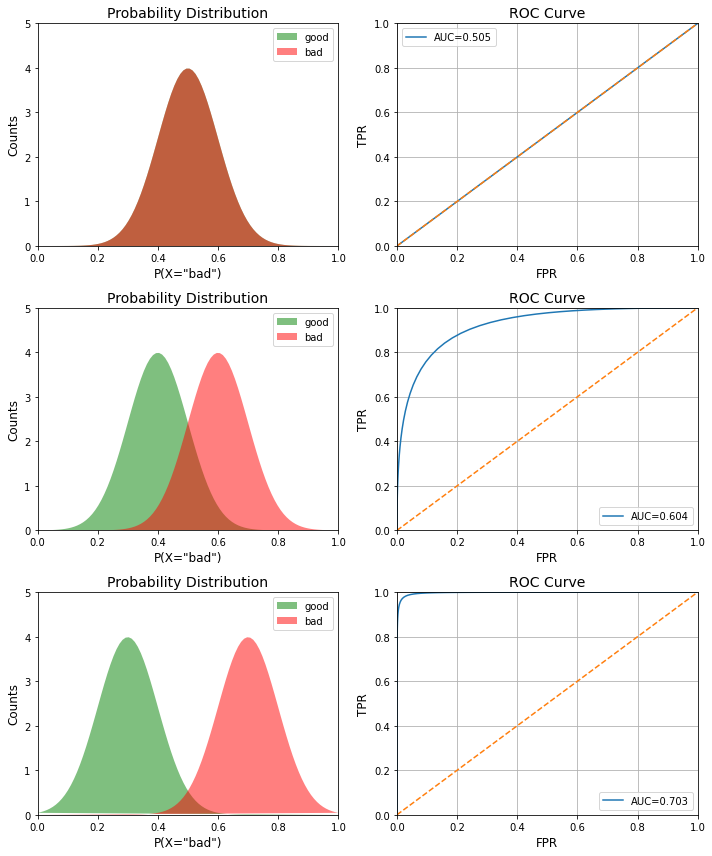

In [ ]:
x = np.linspace(0, 1, num=100)
fig, ax = plt.subplots(3,2, figsize=(10,12))
means_tuples = [(0.5,0.5),(0.4,0.6),(0.3,0.7)]
i=0
for good_mean, bad_mean in means_tuples:
    good_pdf = pdf(x, 0.1, good_mean)
    bad_pdf  = pdf(x, 0.1, bad_mean)
    plot_pdf(good_pdf, bad_pdf, ax[i,0])
    plot_roc(good_pdf, bad_pdf, ax[i,1])
    i+=1
plt.tight_layout()

## COMPARISON OF CFARS
> [Performance Analysis of CFAR Detector Based on Censored Mean and Cell Average](https://iopscience.iop.org/article/10.1088/1742-6596/1237/2/022029/pdf)
> doi:10.1088/1742-6596/1237/2/022029

## Binary Integration (MooN)

> source Radar Systems Analysis and Designs - Bassem R. Mahafza Eq 13.82 and related

Basic idea is that CFAR detection is repeated N times (N separate chirps) and
the final decision declares a target detection if M out of N decision have resulted in a detectinon.

The underlying result follows a binomial distribution.

To maintain Pfa while decreasing Pmiss, one considers that the detection probability and Pmiss probability will be improved by MooN in the following way

$$ P_{Dmn} = \Sigma_{k=M}^{N} \binom{N}{k} \cdot P_{D}^k \cdot (1-P_{D})^{N-k} $$

The resulting being that N chirps (or frames) are needed to secure appropriate detection which will decrease the FTTI

### Swerling fluctuation considerations when doing MooN

One additional considerations after choosing the M and N values is the target fluctuation.

Table 13.1 in ibid makes suggestions for this.
